<a href="https://colab.research.google.com/github/tcglarry/good_stuff/blob/master/Intro_to_Keras_with_W%26B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome!
In this tutorial we'll walk through a simple convolutional neural network to classify the images in the Simpson dataset using Keras.

We’ll also set up Weights & Biases to log models metrics, inspect performance and share findings about the best architecture for the network. In this example we're using Google Colab as a convenient hosted environment, but you can run your own training scripts from anywhere and visualize metrics with W&B's experiment tracking tool.

### Running This Notebook
1. Click "Open in playground" to create a copy of this notebook for yourself.
2. Save a copy in Google Drive for yourself.
3. To enable a GPU, please click Edit > Notebook Settings. Change the "hardware accelerator" to GPU.
4. Step through each section below, pressing play on the code blocks to run the cells.

Results will be logged to a [shared W&B project page](https://app.wandb.ai/wandb/keras-intro).

We highly encourage you to fork this notebook, tweak the parameters, or try the model with your own dataset!

# Setup
Start out by installing the experiment tracking library and setting up your free W&B account:


*   **pip install wandb** – Install the W&B library
*   **import wandb** – Import the wandb library
*   **from wandb.keras import WandbCallback** – Import the wandb [keras callback](https://docs.wandb.com/library/frameworks/keras)


In [0]:
# WandB – Install the W&B library
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.3MB 2.8MB/s 
     |████████████████████████████████| 102kB 11.6MB/s 
     |████████████████████████████████| 92kB 10.8MB/s 
     |████████████████████████████████| 460kB 49.3MB/s 
     |████████████████████████████████| 92kB 10.9MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
     |████████████████████████████████| 256kB 39.7MB/s 
     |████████████████████████████████| 184kB 47.2MB/s 


wandb: WARNING import wandb.keras called before import keras or import tensorflow.keras.  This can lead to a version mismatch, W&B now assumes tensorflow.keras


In [0]:
# Essentials
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve, KFold, cross_val_score, StratifiedKFold

# Models
import tensorflow as tf

# Image Libraries
from PIL import Image, ImageFilter, ImageStat
import imageio, glob, cv2
import os
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import random
random.seed(42)
%matplotlib inline

# Ignore excessive warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Explore The Simpsons Dataset

In [0]:
# Fetch the dataset form Github
!git clone https://github.com/lavanyashukla/simpsons-dataset.git

Cloning into 'simpsons-dataset'...
remote: Enumerating objects: 21934, done.
remote: Total 21934 (delta 0), reused 0 (delta 0), pack-reused 21934
Receiving objects: 100% (21934/21934), 590.28 MiB | 13.03 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (42860/42860), done.


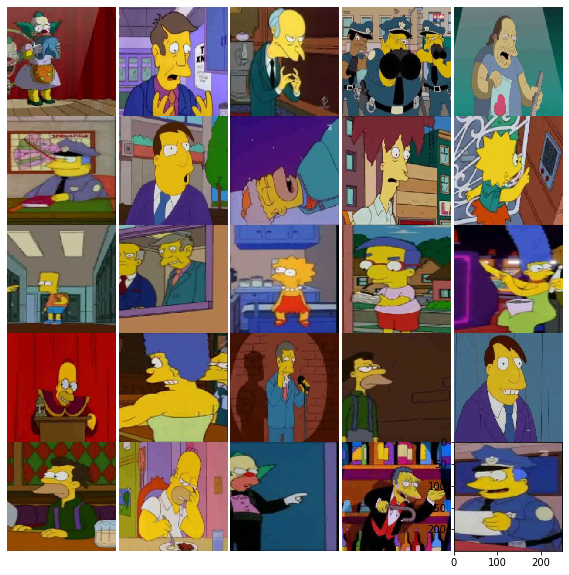

In [0]:
# Visualize images in the dataset
characters = glob.glob('simpsons-dataset/kaggle_simpson_testset/kaggle_simpson_testset/**')
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0, hspace=0)
i = 0
for character in characters[:25]:
    img = cv2.imread(character)
    img = cv2.resize(img, (250, 250))
    plt.axis('off')
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i += 1

### Feature Engineering

In [0]:
# Define the labels for the Simpsons characters we're detecting
character_names = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lenny_leonard', 11:'lisa_simpson',
        12: 'marge_simpson', 13: 'mayor_quimby',14:'milhouse_van_houten', 15: 'moe_szyslak', 
        16: 'ned_flanders', 17: 'nelson_muntz', 18: 'principal_skinner', 19: 'sideshow_bob'}
img_size = 64
num_classes = 20
dir = "simpsons-dataset/simpsons_dataset/simpsons_dataset"

# Load training data
X_train = []
y_train = []
for label, name in character_names.items():
   list_images = os.listdir(dir+'/'+name)
   for image_name in list_images:
       image = imageio.imread(dir+'/'+name+'/'+image_name)
       X_train.append(cv2.resize(image, (img_size,img_size)))
       y_train.append(label)
X_train = np.array(X_train)
y_train = np.array(y_train)

# Split data for cross validation  
X_train = X_train[:10000] 
y_train = y_train[:10000]

X_test = X_train[-100:] 
y_test = y_train[-100:]

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# One hot encode the labels (neural nets only like numbers)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Training A Simple Neural Network

### Define Your Hyperparameters
*   **wandb.init()** – Initialize a new W&B run. Each run is single execution of the training script.
*   **wandb.config** – Save all your hyperparameters in a config object. This lets you use W&B app to sort and compare your runs by hyperparameter values.

In [0]:
# Initilize a new wandb run
wandb.init(entity="wandb", project="keras-intro")

# Default values for hyper-parameters
config = wandb.config # Config is a variable that holds and saves hyperparameters and inputs
config.learning_rate = 0.01
config.epochs = 25
config.img_width=28
config.img_height=28
config.num_classes = 10
config.batch_size = 128
config.validation_size = 5000
config.weight_decay = 0.0005
config.activation = 'relu'
config.optimizer = 'nadam'
config.seed = 42

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Define Your Neural Network
Below, we define a simplified version of a VGG19 model in Keras, and add the following lines of code to log models metrics, visualize performance and output and track our experiments easily:
*   **callbacks=[WandbCallback()]** – Fetch all layer dimensions, model parameters and log them automatically to your W&B dashboard.

In [0]:
%%wandb
# Determine input shape
input_shape = (X_train.shape[1], X_train.shape[2], 3)

# Define the model architecture - This is a simplified version of the VGG19 architecture
model = tf.keras.models.Sequential()

# Set of Conv2D, Conv2D, MaxPooling2D layers with 32 and 64 filters
# Conv2D adds a convolution layer that generates 2 dimensional feature maps to learn different aspects of our image
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', 
                  activation ='relu', input_shape = input_shape))

# MaxPooling2D layer reduces the size of the image representation our convolutional layers learnt,
# and in doing so it reduces the number of parameters and computations the network needs to perform.
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Flattens our array so we can feed the convolution layer outputs (a matrix) into our fully connected layer (an array)
model.add(tf.keras.layers.Flatten())

# Dense layer creates dense, fully connected layers with x inputs and y outputs - it simply outputs the dot product of our inputs and weights
model.add(tf.keras.layers.Dense(512, activation ='relu'))

model.add(tf.keras.layers.Dense(num_classes, activation = "softmax"))

# Define the optimizer
optimizer = tf.keras.optimizers.Nadam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])

# Data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(X_train)

# Fit the model to the training data
model.fit_generator(datagen.flow(X_train, y_train, batch_size=config.batch_size),
                    steps_per_epoch=len(X_train) / 32, epochs=config.epochs,
                    validation_data=(X_test, y_test), verbose=0,
                    callbacks=[WandbCallback(data_type="image", validation_data=(X_test, y_test), labels=character_names),
                                tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

### Make Predictions
In this section we make predictions and add wandb.log() to log custom images - in this case our test images with predicted probabilities overlaid on top.

*   **wandb.log()** – Logs custom objects – these can be images, videos, audio files, HTML, plots, point clouds etc. Here we use wandb.log to log images of Simpson characters overlaid with actual and predicted labels.

In [0]:
def make_predictions(nn_model):
  predicted_images = []
  for i in range(20):
    character = character_names[i]
    # Read in a character image from the test dataset
    image = cv2.imread(np.random.choice([k for k in glob.glob('simpsons-dataset/kaggle_simpson_testset/kaggle_simpson_testset/*.*') if character in k]))
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize image and normalize it
    pic = cv2.resize(image, (64, 64)).astype('float32') / 255.
    
    # Get predictions for the character
    prediction = nn_model.predict(pic.reshape(1, 64, 64,3))[0]
    
    # Get true name of the character
    name = character.split('_')[0].title()
    
    # Format predictions to string to overlay on image
    text = sorted(['{:s} : {:.1f}%'.format(character_names[k].split('_')[0].title(), 100*v) for k,v in enumerate(prediction)], 
        key=lambda x:float(x.split(':')[1].split('%')[0]), reverse=True)[:3]
    
    # Upscale image
    img = cv2.resize(img, (352, 352))
    
    # Create background to overlay text on
    cv2.rectangle(img, (0,260),(215,352),(255,255,255), -1)
    
    # Add text to image -  We add the true probabilities and predicted probabilities on each of the images in the test dataset
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(img, 'True Name : %s' % name, (10, 280), font, 0.7,(73,79,183), 2, cv2.LINE_AA)
    for k, t in enumerate(text):
        cv2.putText(img, t, (10, 300+k*18), font, 0.65,(0,0,0), 2, cv2.LINE_AA)
        
    # Add predicted image from test dataset with annotations to array
    predicted_images.append(wandb.Image(img, caption="Actual: %s" % name))     
        
  # Log images from test set to wandb automatically, along with predicted and true labels by passing pytorch tensors with image data into wandb.Image
  # You can use wandb.log() to log any images, video, audio, 3D objects like point clouds, plots, HTML etc.
  # For full details please see https://docs.wandb.com/library/python/log
  wandb.log({"predictions": predicted_images})

In [0]:
make_predictions(model)

# Visualize Predictions Live

## Project Overview
1. Check out the [project page](https://app.wandb.ai/wandb/keras-intro) to see your results in the shared project. 
1. Press 'option+space' to expand the runs table, comparing all the results from everyone who has tried this script. 
1. Click on the name of a run to dive in deeper to that single run on its own run page.

![](https://paper-attachments.dropbox.com/s_92F7A2BE132D5E4492B0E3FF3430FFF0FB2390A4135C0D77582A2D21A2EF8567_1574108018540_Screenshot+2019-11-18+12.13.29.png)


## Visualize Performance
Click through to a single run to see more details about that run. For example, on [this run page](https://app.wandb.ai/wandb/keras-intro/runs/tjbbvw5o) you can see the performance metrics I logged when I ran this script.

![](https://paper-attachments.dropbox.com/s_92F7A2BE132D5E4492B0E3FF3430FFF0FB2390A4135C0D77582A2D21A2EF8567_1574108139591_Screenshot+2019-11-18+12.14.50.png)


## Review Code
The overview tab picks up a link to the code. In this case, it's a link to the Google Colab. If you're running a script from a git repo, we'll pick up the SHA of the latest git commit and give you a link to that version of the code in your own GitHub repo.

![](https://paper-attachments.dropbox.com/s_92F7A2BE132D5E4492B0E3FF3430FFF0FB2390A4135C0D77582A2D21A2EF8567_1574108018524_Screenshot+2019-11-18+12.13.14.png)

## Visualize System Metrics
The System tab on the runs page lets you visualize how resource efficient your model was. It lets you monitor the GPU, memory, CPU, disk, and network usage in one spot.

![](https://paper-attachments.dropbox.com/s_92F7A2BE132D5E4492B0E3FF3430FFF0FB2390A4135C0D77582A2D21A2EF8567_1574107906110_Screenshot+2019-11-18+12.11.39.png)


## Next Steps
As you can see running sweeps is super easy! We highly encourage you to fork this notebook, tweak the parameters, or try the model with your own dataset!


## More about Weights & Biases
We're always free for academics and open source projects. Email carey@wandb.com with any questions or feature suggestions. Here are some more resources:

1. [Documentation](http://docs.wandb.com) - Python docs
2. [Gallery](https://app.wandb.ai/gallery) - example reports in W&B
3. [Articles](https://www.wandb.com/articles) - blog posts and tutorials
4. [Community](bit.ly/wandb-forum) - join our Slack community forum